In [29]:
#https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
#https://machinelearningmastery.com/multi-step-time-series-forecasting/

import re
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [30]:
#Supporting Functions
def rename_col(df, suffix):
    for col_name in list(df):
        col_name_new = col_name +  "_" + suffix
        df.rename(columns={col_name: col_name_new}, inplace=True)
        
    return df

def calculate_returns(df):
    df['returnsClosePrev1'] = df['Last']-df['Last'].shift(-1)
    df['returnsClosePrev2'] = df['Last']-df['Last'].shift(-2)
    df['returnsClosePrev3'] = df['Last']-df['Last'].shift(-3)
    df['returnsClosePrev4'] = df['Last']-df['Last'].shift(-4)
    df['returnsClosePrev5'] = df['Last']-df['Last'].shift(-5)
    df['returnsClosePrev10'] = df['Last']-df['Last'].shift(-10)
    
    df['returnsCloseNext1'] = df['Last']-df['Last'].shift(+1)
    df['returnsCloseNext2'] = df['Last']-df['Last'].shift(+2)
    df['returnsCloseNext3'] = df['Last']-df['Last'].shift(+3)
    df['returnsCloseNext4'] = df['Last']-df['Last'].shift(+4)
    df['returnsCloseNext5'] = df['Last']-df['Last'].shift(+5)
    df['returnsCloseNext10'] = df['Last']-df['Last'].shift(+10)

    
    return df

def plot_line(df, wanted_col, date_col, img_title, y_label):
    
    #Generic price change plot line comparison
    fig = go.Figure()

    cols = list(df)

    cols = [ele for ele in cols if ele in wanted_col] 

    data = []
    for col_name in cols:

        data.append(go.Scatter(x=df[date_col].dt.strftime(date_format='%Y-%m-%d'), y=df[col_name],
                        #mode='lines',
                        name=col_name))
        #pdb.set_trace()
    layout = go.Layout(dict(title = img_title,
                      xaxis = dict(title = ''),
                      yaxis = dict(title = y_label),
                      ),legend=dict(
                    orientation="h"))
    py.iplot(dict(data=data, layout=layout), filename='basic-line', image_width=800,
        image_height=500)
    
    
def read_file(filename, symbol):
    df = pd.read_csv(filename)
    df.rename(columns={"Open Int": "Open_Int"}, inplace=True)
    df['Time'] = df['Time'].astype('datetime64[ns]')
    df["Symbol"] = symbol
    #df = calculate_returns(df)
    print(f'{df.shape[0]} samples and {df.shape[1]} features in the {symbol} contract dataset.')
    return df

In [49]:
ug_data_mar20 = read_file('./marketdata/soybean/zsh20_daily_price-history-10-25-2019.csv', "ZSH20")
ug_data_mar19 = read_file('./marketdata/soybean/zsh19_daily_price-history-10-25-2019.csv', "ZSH19")
ug_data_mar19['Adjusted_Time'] = ug_data_mar19['Time'].apply(lambda x: x + pd.DateOffset(years=1))
ug_data_mar18 = read_file('./marketdata/soybean/zsh18_daily_price-history-10-25-2019.csv', "ZSH18")
ug_data_mar18['Adjusted_Time'] = ug_data_mar18['Time'].apply(lambda x: x + pd.DateOffset(years=2))
ug_data_mar17 = read_file('./marketdata/soybean/zsh17_daily_price-history-10-25-2019.csv', "ZSH17")
ug_data_mar17['Adjusted_Time'] = ug_data_mar17['Time'].apply(lambda x: x + pd.DateOffset(years=3))
ug_data_mar16 = read_file('./marketdata/soybean/zsh16_daily_price-history-10-25-2019.csv', "ZSH16")
ug_data_mar16['Adjusted_Time'] = ug_data_mar16['Time'].apply(lambda x: x + pd.DateOffset(years=4))
ug_data_mar15 = read_file('./marketdata/soybean/zsh15_daily_price-history-10-25-2019.csv', "ZSH15")
ug_data_mar15['Adjusted_Time'] = ug_data_mar15['Time'].apply(lambda x: x + pd.DateOffset(years=5))
ug_data_mar14 = read_file('./marketdata/soybean/zsh14_daily_price-history-10-25-2019.csv', "ZSH14")
ug_data_mar14['Adjusted_Time'] = ug_data_mar14['Time'].apply(lambda x: x + pd.DateOffset(years=6))
ug_data_mar13 = read_file('./marketdata/soybean/zsh13_daily_price-history-10-25-2019.csv', "ZSH13")
ug_data_mar13['Adjusted_Time'] = ug_data_mar13['Time'].apply(lambda x: x + pd.DateOffset(years=7))
ug_data_mar12 = read_file('./marketdata/soybean/zsh12_daily_price-history-10-25-2019.csv', "ZSH12")
ug_data_mar12['Adjusted_Time'] = ug_data_mar12['Time'].apply(lambda x: x + pd.DateOffset(years=8))
ug_data_mar20.tail()

490 samples and 9 features in the ZSH20 contract dataset.
585 samples and 9 features in the ZSH19 contract dataset.
585 samples and 9 features in the ZSH18 contract dataset.
584 samples and 9 features in the ZSH17 contract dataset.
584 samples and 9 features in the ZSH16 contract dataset.
584 samples and 9 features in the ZSH15 contract dataset.
586 samples and 9 features in the ZSH14 contract dataset.
588 samples and 9 features in the ZSH13 contract dataset.
585 samples and 9 features in the ZSH12 contract dataset.


,Time,Open,High,Low,Last,Change,Volume,Open_Int,Symbol
485,2017-11-21,998.0,998.0,998.0,998.0,-0.5,0,0,ZSH20
486,2017-11-20,998.5,998.5,998.5,998.5,2.0,0,0,ZSH20
487,2017-11-17,996.5,996.5,996.5,996.5,13.5,0,0,ZSH20
488,2017-11-16,983.0,983.0,983.0,983.0,-2.0,0,0,ZSH20
489,2017-11-15,985.0,985.0,985.0,985.0,6.5,0,0,ZSH20


In [ ]:
#Concating March prices 
#frames = [ug_data_mar20, ug_data_mar19, ug_data_mar18, ug_data_mar17]
#ug_data_mar16, ug_data_mar15, ug_data_mar14, ug_data_mar13, ug_data_mar12

#result = pd.concat(frames, ignore_index=True)
#result = pd.merge(ug_data_july, result,  left_on='Date_july', right_on='Date_mar', how='outer')
#pd.concat([result, ug_data_july], axis=1)
#result.drop(['Date_mar', 'Date_may'], axis=1, inplace=True)
#result.reset_index(drop=True)
#result.shape

In [52]:
ug_data_mar20 = ug_data_mar20.sort_values('Time')
ug_data_mar20.head()

,Time,Open,High,Low,Last,Change,Volume,Open_Int,Symbol
489,2017-11-15,985.0,985.0,985.0,985.0,6.5,0,0,ZSH20
488,2017-11-16,983.0,983.0,983.0,983.0,-2.0,0,0,ZSH20
487,2017-11-17,996.5,996.5,996.5,996.5,13.5,0,0,ZSH20
486,2017-11-20,998.5,998.5,998.5,998.5,2.0,0,0,ZSH20
485,2017-11-21,998.0,998.0,998.0,998.0,-0.5,0,0,ZSH20


In [55]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [53]:
# transform data to be stationary
raw_values = ug_data_mar20["Last"].values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-100], supervised_values[-100:]

#For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

1) Test RMSE: 8.569
2) Test RMSE: 8.572
3) Test RMSE: 8.588
4) Test RMSE: 8.591
5) Test RMSE: 8.572
6) Test RMSE: 8.565
7) Test RMSE: 8.553
8) Test RMSE: 8.580
9) Test RMSE: 8.579
10) Test RMSE: 8.572
11) Test RMSE: 8.580
12) Test RMSE: 8.572
13) Test RMSE: 8.561
14) Test RMSE: 8.574
15) Test RMSE: 8.566
16) Test RMSE: 8.558
17) Test RMSE: 8.551
18) Test RMSE: 8.565
19) Test RMSE: 8.573
20) Test RMSE: 8.555
21) Test RMSE: 8.563
22) Test RMSE: 8.568
23) Test RMSE: 8.572
24) Test RMSE: 8.558
25) Test RMSE: 8.542
26) Test RMSE: 8.562
27) Test RMSE: 8.561
28) Test RMSE: 8.548
29) Test RMSE: 8.560
30) Test RMSE: 8.567
            rmse
count  30.000000
mean    8.566601
std     0.011151
min     8.542206
25%     8.560629
50%     8.566391
75%     8.572425
max     8.590681


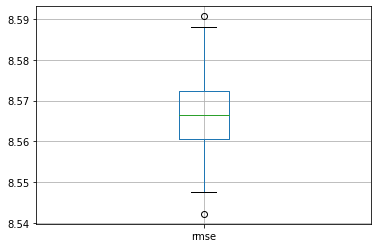

In [57]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 50, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-100:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

In [63]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	#print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
#report performance
rmse = sqrt(mean_squared_error(raw_values[-100:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.567


In [69]:
test_scaled[0, -1]

-0.02953586497890298

In [67]:
test_scaled

array([[-0.3164557 , -0.02953586],
       [-0.02953586, -0.34177215],
       [-0.34177215,  0.13924051],
       [ 0.13924051,  0.07172996],
       [ 0.07172996,  0.55274262],
       [ 0.55274262,  0.28270042],
       [ 0.28270042,  0.25738397],
       [ 0.25738397,  0.47679325],
       [ 0.47679325,  0.06329114],
       [ 0.06329114, -0.25738397],
       [-0.25738397,  0.45147679],
       [ 0.45147679, -0.42616034],
       [-0.42616034,  0.18987342],
       [ 0.18987342, -0.24050633],
       [-0.24050633, -0.23206751],
       [-0.23206751, -0.14767932],
       [-0.14767932,  0.35021097],
       [ 0.35021097, -0.4092827 ],
       [-0.4092827 , -0.29113924],
       [-0.29113924,  0.34177215],
       [ 0.34177215, -0.44303797],
       [-0.44303797,  0.13924051],
       [ 0.13924051,  0.25738397],
       [ 0.25738397,  0.30801688],
       [ 0.30801688,  0.16455696],
       [ 0.16455696,  0.47679325],
       [ 0.47679325, -0.35021097],
       [-0.35021097, -0.43459916],
       [-0.43459916,

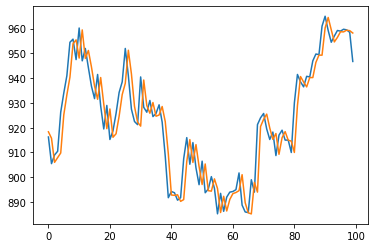

In [61]:
# line plot of observed vs predicted
pyplot.plot(raw_values[-100:])
pyplot.plot(predictions)
pyplot.show()